In [111]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore")

# Clustering RFM clientes

In [112]:
cnxn = pyodbc.connect(
    driver='{iSeries Access ODBC Driver}',
    system='192.168.100.2',
    uid='TBLPRDUSR',
    pwd='bbbb')
cursor = cnxn.cursor()
#cnxn.close()

In [113]:
#Cargue de la data desde el ERP de Dispapeles y se guarda en df
cursor.execute('SELECT DSTCOD AS "Codigo distrito", VTAZNA AS "Codigo zona", VTANIT AS "Nit cliente", ((2022 - LEFT(MAX(VTAFCH),4)) * 12 ) + (6 - SUBSTRING(MAX(VTAFCH),5,2)) AS "Recency", SUM(A.VTAVLRVTA) AS "Monetary", COUNT( DISTINCT LEFT(VTAFCH, 6)) AS "Frequency" FROM SIDPRDDTA.VTAHEC A WHERE PRMCOD = 1 AND A.DSTCOD = 10 AND A.VTAZNA < 96 AND LEFT(VTAFCH,6) BETWEEN 202011 AND 202210 GROUP BY DSTCOD, VTAZNA, VTANIT')
rows = cursor.fetchall()
df = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])

In [114]:
#Se añade una key de Distrito-Zona para hacer mas facil la identificacion cuando se usa todo el pais
#Se genera la calificacion de Recency basado en los valores máximos
df['Distrito-Zona'] = df['Codigo distrito'].astype(str) + '-' + df['Codigo zona'].astype(str)
df['Recency'] = max(df['Recency'])-df['Recency']+1
df['Monetary'] = df['Monetary'] / 1000000

In [115]:
df

,Codigo distrito,Codigo zona,Nit cliente,Recency,Monetary,Frequency,Distrito-Zona
0,10,1,14317512,5,0.574372,1,10-1
1,10,1,17172243,24,32.35119945,14,10-1
2,10,1,19173449,17,1.279167,2,10-1
3,10,1,19322486,24,39.58834908,17,10-1
4,10,1,23588105,18,19.28482092,3,10-1
...,...,...,...,...,...,...,...
3431,10,83,901336804,22,3.902976,1,10-83
3432,10,83,901470413,24,1.320852,1,10-83
3433,10,83,901476001,24,8.72329465,2,10-83
3434,10,83,901478176,24,17.0471414,3,10-83


#### Prueba del clustering a nivel general

In [116]:
zonas = list(np.unique(df['Distrito-Zona'].values))

for z in zonas:
    shape_0 = len(df[df['Distrito-Zona'] == z])
    if shape_0 < 3:
        print(f"Omitir zona {z}")

Omitir zona 10-82


In [1]:
df = df[df['Distrito-Zona'] != '10-82']
zonas = list(np.unique(df['Distrito-Zona'].values))

NameError: name 'df' is not defined

In [134]:
learner = KMeans(n_clusters = 5, init = 'k-means++')

list_total = []
for z in zonas:
    df_zona = df[df['Distrito-Zona']==z]
    X = df_zona[['Recency', 'Monetary', 'Frequency']]
    y = learner.fit_predict(X)
    df_zona['Cluster'] = y.tolist()
    list_total.append(df_zona)

In [135]:
df_total = pd.concat(list_total)
df_total

,Codigo distrito,Codigo zona,Nit cliente,Recency,Monetary,Frequency,Distrito-Zona,Cluster
0,10,1,14317512,5,0.574372,1,10-1,2
1,10,1,17172243,24,32.35119945,14,10-1,2
2,10,1,19173449,17,1.279167,2,10-1,2
3,10,1,19322486,24,39.58834908,17,10-1,2
4,10,1,23588105,18,19.28482092,3,10-1,2
...,...,...,...,...,...,...,...,...
683,10,9,901276512,5,28.09068022,5,10-9,0
684,10,9,901291985,4,1.791387,2,10-9,0
685,10,9,901355632,11,0.64787,1,10-9,0
686,10,9,901528604,24,102.03233168,9,10-9,0


Text(0.5, 0, 'Frequency')

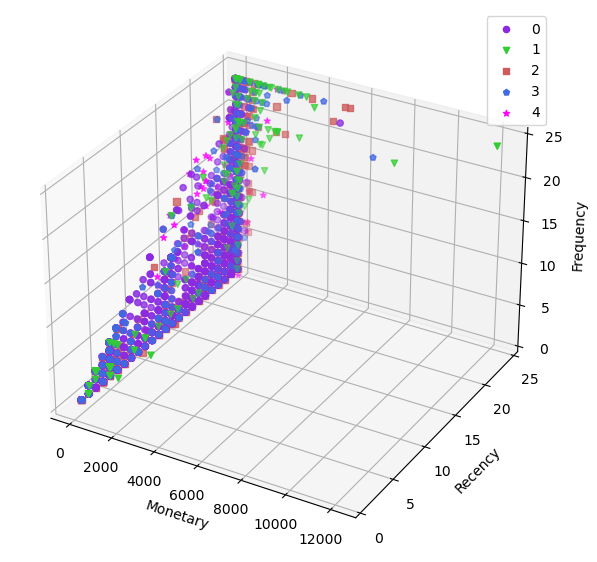

In [136]:
fig = plt.figure(figsize=(7,10))
ax = fig.gca(projection='3d')

m = ['o', 'v', 's', 'p', '*']
c =  ['blueviolet', 'limegreen', 'indianred', 'royalblue', 'magenta']
leg = ['0','1','2','3','4']

for i in range(5):
    df_plot = df_total[df_total['Cluster'] == i]
    ax.scatter(df_plot['Monetary'], df_plot['Recency'], df_plot['Frequency'], marker= m[i], c= c[i])
    
ax.legend(leg)
ax.set_xlabel('Monetary')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')

#### Construccion del clustering a nivel de clientes por zona

In [31]:
base_dtos_zna =  df.groupby(['Distrito-Zona']).count()
base_dtos_zna = base_dtos_zna.loc[base_dtos_zna['Codigo distrito'] >= 5]
base_dtos_zna.reset_index(inplace=True)
base_dtos_zna = base_dtos_zna['Distrito-Zona']
base_dtos_zna = base_dtos_zna.drop_duplicates()
# base_dtos_zna

In [ ]:
for i in base_dtos_zna:
    ## Definicion de datos para usar en el algoritmo
    df_prueba = df[df['Distrito-Zona'] == i]
    X = df_prueba.iloc[:,3:6].values
    X
    ## K-means
    k_means_optimum = KMeans(n_clusters = 5, init = 'k-means++',  random_state=42)
    y = k_means_optimum.fit_predict(X)
    df_prueba['cluster'] = y  
    #Diccionario resultado
    model_dtos_zna = {"Distrito": df_prueba['Codigo distrito'], "Zona": df_prueba['Codigo zona'],
                      "Nit cliente": df_prueba['Nit cliente'], 'Recency': df_prueba['Recency'],
                      "Monetary": df_prueba['Monetary'], "Frequency": df_prueba['Frequency'],
                      "Cluster": df_prueba['cluster']}
    #DataFrame
    df_model = pd.DataFrame(model_dtos_zna)
    #Guardar archivos
    df_model.to_csv(f'C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Kmeans++/Modelo clientes x zonas/Distrito-zona {i}.csv', index = False, decimal = ",")
    print(f'Distrito-Zna {i} listo!')

In [ ]:
df_prueba

# Clustering RFM productos

In [ ]:
df = pd.read_excel("C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/base_RFM_productos.xlsx")

In [ ]:
df['Distrito-Zona'] = df['Codigo distrito'].astype(str) + '-' + df['Codigo zona historica'].astype(str)
df['Distrito-Zona-Gerente'] = df['Distrito-Zona'] + '-' + df['Gerente']
df

#### Construccion del clustering a nivel de productos por zona

In [ ]:
base_ptos_zna =  df.groupby(['Distrito-Zona']).count()
base_ptos_zna = base_ptos_zna.loc[base_ptos_zna['Codigo distrito'] >= 5]
base_ptos_zna.reset_index(inplace=True)
base_ptos_zna = df['Distrito-Zona']
base_ptos_zna = base_ptos_zna.drop_duplicates()
base_ptos_zna

In [ ]:
for i in base_ptos_zna:
    ## Definicion de datos para usar en el algoritmo
    df_prueba = df[df['Distrito-Zona'] == i]
    X = df_prueba.iloc[:,4:7].values
    X
    ## K-means
    k_means_optimum = KMeans(n_clusters = 5, init = 'k-means++',  random_state=42)
    y = k_means_optimum.fit_predict(X)
    df_prueba['cluster'] = y  
    #Diccionario resultado
    model_dtos_zna = {"Distrito": df_prueba['Codigo distrito'], "Zona": df_prueba['Codigo zona historica'],
                      "Gerente": df_prueba['Gerente'], "Linea": df_prueba['Línea CAM'],'Recency': df_prueba['Recency'],
                      "Monetary": df_prueba['Monetary'], "Frequency": df_prueba['Frequency'],
                      "Cluster": df_prueba['cluster']}
    #DataFrame
    df_model = pd.DataFrame(model_dtos_zna)
    #Guardar archivos
    df_model.to_csv(f'C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/Análisis clustering/Kmeans++/Modelo gerencias x zonas/Distrito-zona {i}.csv', index = False, decimal = ",")
    print(f'Distrito-Zna {i} listo!')